In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
dirhome = r'D:\covid-chestxray-dataset\COVID-19_Radiography_Dataset'
covid_dir = os.path.join(dirhome, 'COVID')
normal_dir = os.path.join(dirhome, 'Normal')

In [225]:
img_covid = cv.imread(fr'{covid_dir}\\COVID-16.png',0)
img_normal = cv.imread(fr'{normal_dir}\\Normal-25.png',0)

Text(0.5, 1.0, 'Normal')

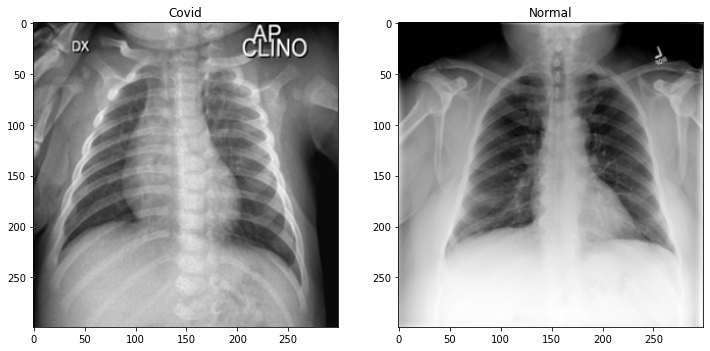

In [204]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_covid,cmap='gray')
plt.title('Covid')

ax2 = fig.add_subplot(122)
plt.imshow(img_normal,cmap='gray')
plt.title('Normal')

In [5]:
# Region of Interest
def roi(event, x, y, flags, param):
    global image_to_show, x_init, y_init, top_left_pt, bottom_right_pt, cropping

    if event == cv.EVENT_LBUTTONDOWN:
        cropping = True
        x_init, y_init = x, y
        image_to_show = np.copy(image)
        print(f'Ponto inicial em X {x_init}')
        print(f'Ponto inicial em Y {y_init}')

    elif event == cv.EVENT_MOUSEMOVE:
        if cropping == True:
            image_to_show = np.copy(image)
            cv.rectangle(image_to_show, (x_init, y_init),
                          (x, y), (0, 0, 255), 2)

    elif event == cv.EVENT_LBUTTONUP:
        cropping = False
        top_left_pt, bottom_right_pt = x, y
        print(f'Ponto superior {top_left_pt}')
        print(f'Ponto inferior {bottom_right_pt}')

In [27]:
# Estados iniciais do mouse
cropping = False
x_init, y_init, top_left_pt, bottom_right_pt = 0, 0, 0, 0

image = np.copy(img_covid)
image_to_show = np.copy(img_covid)
    
cv.namedWindow('image')
cv.setMouseCallback('image', roi)

while True:

    cv.imshow('image', image_to_show)

    if cv.waitKey(1) == 13:
        break

cv.destroyAllWindows()

Ponto inicial em X 8
Ponto inicial em Y 39
Ponto superior 291
Ponto inferior 291


In [226]:
pontos = [y_init, bottom_right_pt, x_init, top_left_pt]
img_covid = img_covid[pontos[0]:pontos[1], pontos[2]:pontos[3]]

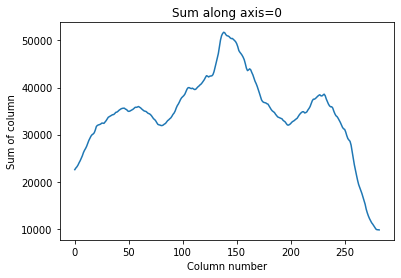

In [227]:
def eraseMax(img,eraseLineCenter=0,eraseLineWidth=30,draw=False):
    sumpix0=np.sum(img,0)
    if draw:
        plt.plot(sumpix0)
        plt.title('Sum along axis=0')
        plt.xlabel('Column number')
        plt.ylabel('Sum of column')
    max_r2=np.int_(len(sumpix0)/3)+np.argmax(sumpix0[np.int_(len(sumpix0)/3):np.int_(len(sumpix0)*2/3)])
    cv.line(img,(max_r2+eraseLineCenter,0),(max_r2+eraseLineCenter,512),0,eraseLineWidth)
    return img

img_erased = eraseMax(img_covid,draw=True)

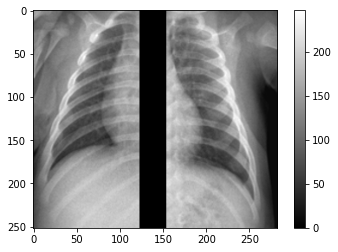

In [228]:
plt.imshow(img_erased,cmap='gray')
plt.colorbar()

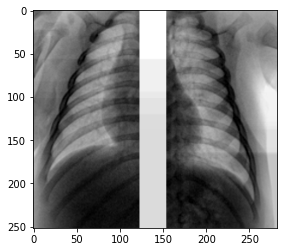

In [234]:
ker = 169
kernel = np.ones((ker,ker),np.uint8)
blackhat = cv.morphologyEx(img_erased, cv.MORPH_BLACKHAT, kernel)    
plt.imshow(blackhat,cmap='gray')

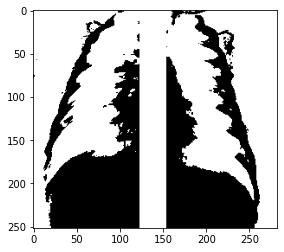

In [235]:
threshold = 75
ret, threshn = cv.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh,cmap='gray')

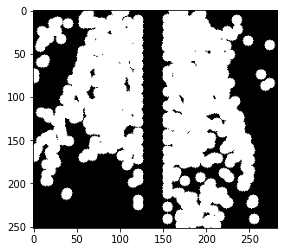

In [236]:
def get_cmask(img, maxCorners=900, qualityLevel=0.001, minDistance=1,Cradius=6):
    corners = cv.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x,y = corner.ravel()
        cv.circle(cmask,(x,y),Cradius,1,-1)
    return cmask

cmask = get_cmask(img_erased)
plt.imshow(cmask,cmap='gray')

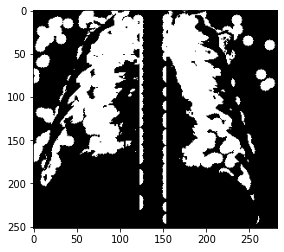

In [237]:
mask = np.multiply(cmask,thresh).astype('uint8')
plt.imshow(mask,cmap='gray')

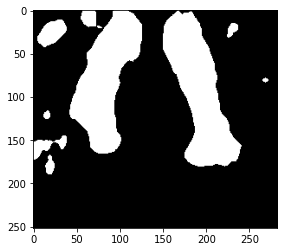

In [238]:
median = cv.medianBlur(mask,23) 
plt.imshow(median,cmap='gray')

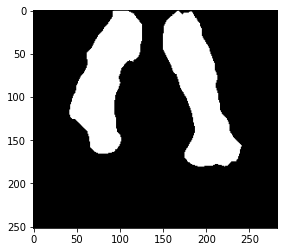

In [239]:
def contourMask(image):
    contours,hierc = cv.findContours(image,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE) 
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv.drawContours(mask, contours, np.argmax(area), (255), -1)#draw largest contour-usually right lung   
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)]=0
    if area[np.argmax(area)] > temp/10:#make sure 2nd largest contour is also lung, not 2 lungs connected
        cv.drawContours(mask, contours, np.argmax(area), (255), -1)#draw second largest contour  
    contours.clear() 
    return mask

contour_mask = contourMask(median).astype('uint8')
plt.imshow(contour_mask,cmap='gray')

In [240]:
contour_mask = cv.medianBlur(contour_mask,23)

Text(0.5, 1.0, 'Mask')

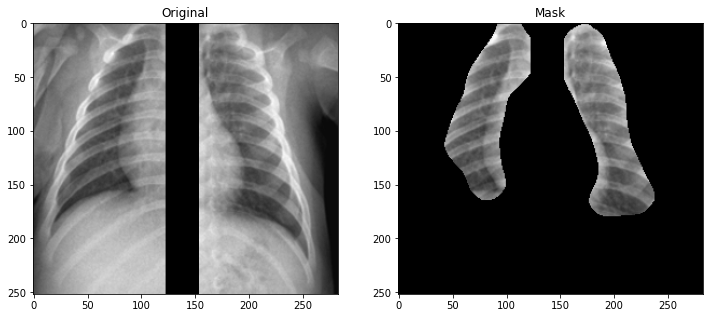

In [241]:
result = cv.bitwise_and(img_covid, contour_mask)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_covid,cmap='gray')
plt.title('Original')

ax1 = fig.add_subplot(122)
plt.imshow(result,cmap='gray')
plt.title('Mask')

Text(0.5, 1.0, 'Mask')

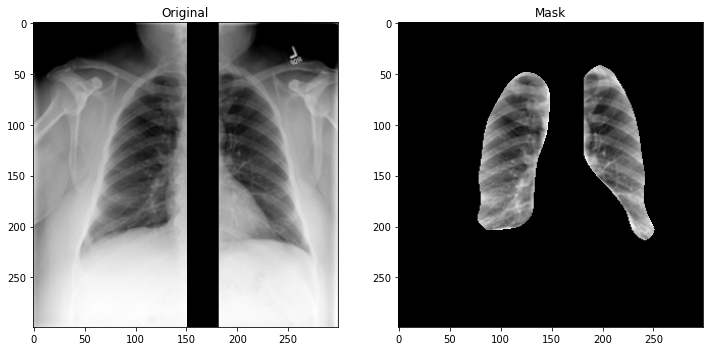

In [180]:
result = cv.bitwise_and(img_normal, contour_mask)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
plt.imshow(img_normal,cmap='gray')
plt.title('Original')

ax1 = fig.add_subplot(122)
plt.imshow(result,cmap='gray')
plt.title('Mask')